In [0]:
# %pip install yfinance pandas numpy matplotlib scikit-learn

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, stddev, avg, log, when
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, TimestampType
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime, timedelta

In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
spark = SparkSession.builder.appName("AAPL_Prediction").getOrCreate()

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")


In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

The code below is only if our API would stop working, but do we need that for the uni project? I was trying to keep as simple code as possible

In [0]:
# try:
#     spark_df = get_alpha_vantage_data(symbol, api_key)
# except:
#     print("Using simulated fallback data")
#     dates = pd.date_range(end=datetime.now(), periods=365*15, freq='B')
#     base = pd.Series(np.linspace(100, 200, len(dates)))
#     price = base + pd.Series(np.random.normal(0, 1, len(dates))).cumsum()
#     fallback = pd.DataFrame({
#         'Date': dates,
#         'open': price * np.random.uniform(0.995, 1.005, len(dates)),
#         'high': price * np.random.uniform(1.000, 1.010, len(dates)),
#         'low': price * np.random.uniform(0.990, 1.000, len(dates)),
#         'close': price,
#         'volume': np.random.randint(5e7, 15e7, len(dates))
#     })
#     spark_df = spark.createDataFrame(fallback)

#### Visualize the data

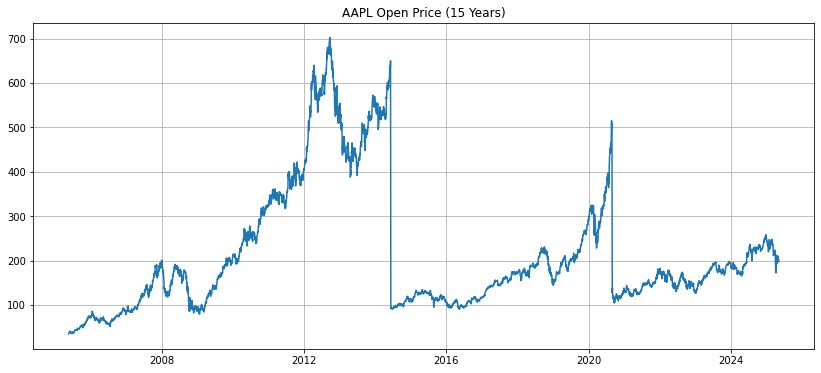

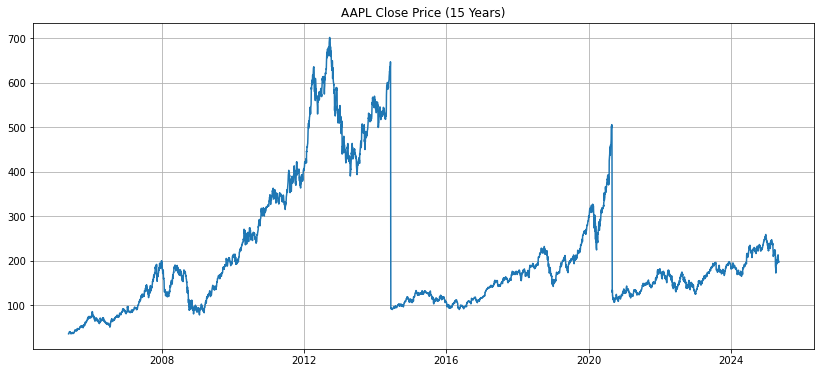

In [0]:
pandas_df = spark_df.select("Date", "close","open").orderBy("Date").toPandas()


plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['open'])
plt.title('AAPL Open Price (15 Years)')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['close'])
plt.title('AAPL Close Price (15 Years)')
plt.grid(True)
plt.show()

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        #source: https://www.ig.com/en/trading-strategies/apple-stock-split-2020--what-you-need-to-know-230803
        splits = {
            '2005-02-28': 2, # two-for-one stock split on 28 February 2005
            '2014-06-09': 7, #  seven-for-one stock split on 9th of June 2014
            '2020-08-31': 4 #  four-for-one stock split on 31st of August 2020
        }
        for date_str, ratio in splits.items():
            date = pd.Timestamp(date_str)
            mask = df.index < date
            for col in ['open', 'high', 'low', 'close']:
                df.loc[mask, col] = df.loc[mask, col] / ratio
            df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * ratio

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

In [0]:
# try:
#     spark_df = get_alpha_vantage_data(symbol, api_key)
# except:
#     print("Using simulated fallback data")
#     dates = pd.date_range(end=datetime.now(), periods=365*20, freq='B')
#     base = pd.Series(np.linspace(100, 200, len(dates)))
#     price = base + pd.Series(np.random.normal(0, 1, len(dates))).cumsum()
#     fallback = pd.DataFrame({
#         'Date': dates,
#         'open': price * np.random.uniform(0.995, 1.005, len(dates)),
#         'high': price * np.random.uniform(1.000, 1.010, len(dates)),
#         'low': price * np.random.uniform(0.990, 1.000, len(dates)),
#         'close': price,
#         'volume': np.random.randint(5e7, 15e7, len(dates))
#     })
#     spark_df = spark.createDataFrame(fallback)

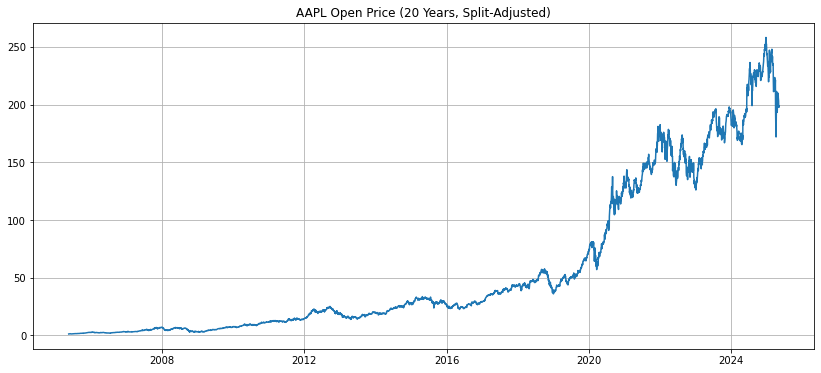

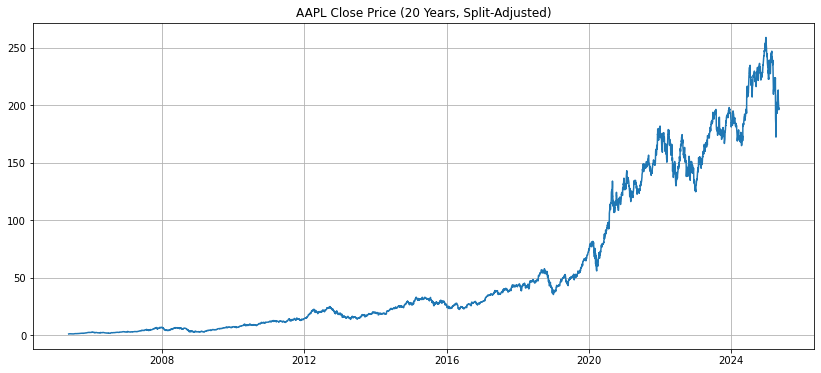

In [0]:
pandas_df = spark_df.select("Date", "close","open").orderBy("Date").toPandas()


plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['open'])
plt.title('AAPL Open Price (20 Years, Split-Adjusted)')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['close'])
plt.title('AAPL Close Price (20 Years, Split-Adjusted)')
plt.grid(True)
plt.show()

Small feature engineering
| Feature Name    | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| window30      | 30-row rolling window |
| window7        | 7-row rolling window |     
| return        | daily percentage change between open and close (price change relative to opening price) |
| log_return   | Logarithmic return between the current day’s closing price and the previous day’s closing price  |
| volatility_30 | volatility measures how much the price of an asset fluctuates over time (in this case in 30 days) |
| ma_7          | 7-day moving average of closing prices (short-term trend) |
| ma_30         | 30-day moving average of closing prices (longer-term trend)  |
| volume_ma_7   | 7-day moving average of volume (detect unusual trading activity) |
| close_lag_1/2/3| closing price 1, 2, and 3 days ago (time series context)|
| NextDayClose  | Next day’s closing price — used as the target variable for prediction |


rolling_window: https://trendspider.com/learning-center/enhancing-your-trading-strategy-with-rolling-window-indicators/

In [0]:
window30 = Window.orderBy("Date").rowsBetween(-30, -1)
window7 = Window.orderBy("Date").rowsBetween(-7, -1)

spark_df = spark_df.withColumn("return", (col("close") - col("open")) / col("open"))
spark_df = spark_df.withColumn("log_return", log(col("close") / lag("close", 1).over(Window.orderBy("Date"))))
spark_df = spark_df.withColumn("volatility_30", stddev("return").over(window30))
spark_df = spark_df.withColumn("ma_7", avg("close").over(window7))
spark_df = spark_df.withColumn("ma_30", avg("close").over(window30))
spark_df = spark_df.withColumn("volume_ma_7", avg("volume").over(window7))

for lag_day in [1, 2, 3]:
    spark_df = spark_df.withColumn(f"close_lag_{lag_day}", lag("close", lag_day).over(Window.orderBy("Date")))

spark_df = spark_df.withColumn("NextDayClose", lag("close", -1).over(Window.orderBy("Date")))
spark_df = spark_df.na.drop()

Visualisations of newly created features

In [0]:
pandas_df = spark_df.select("Date", "close", "return","ma_7","ma_30","volatility_30","log_return").orderBy("Date").toPandas()


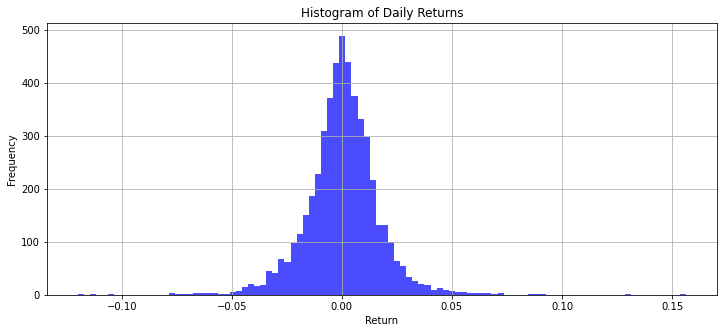

In [0]:

plt.figure(figsize=(12, 5))
plt.hist(pandas_df['return'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

%md
* Most daily returns are small, the stock doesnt usually change much in one day
* There are occasional negative or positive returns - these can represent volatile days or extreme events like 2008 market crash or COVID in 2020
* Symmetric shape which suggest that returns are normally distributed

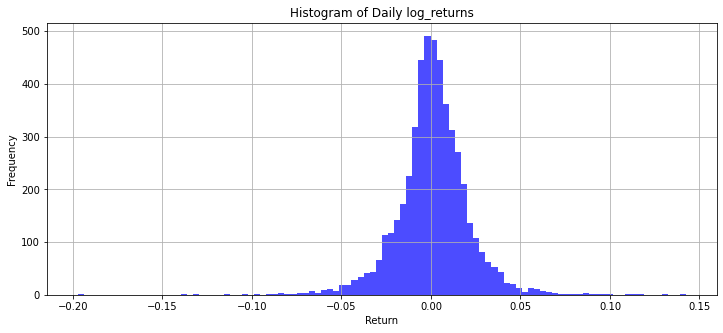

In [0]:

plt.figure(figsize=(12, 5))
plt.hist(pandas_df['log_return'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Daily log_returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

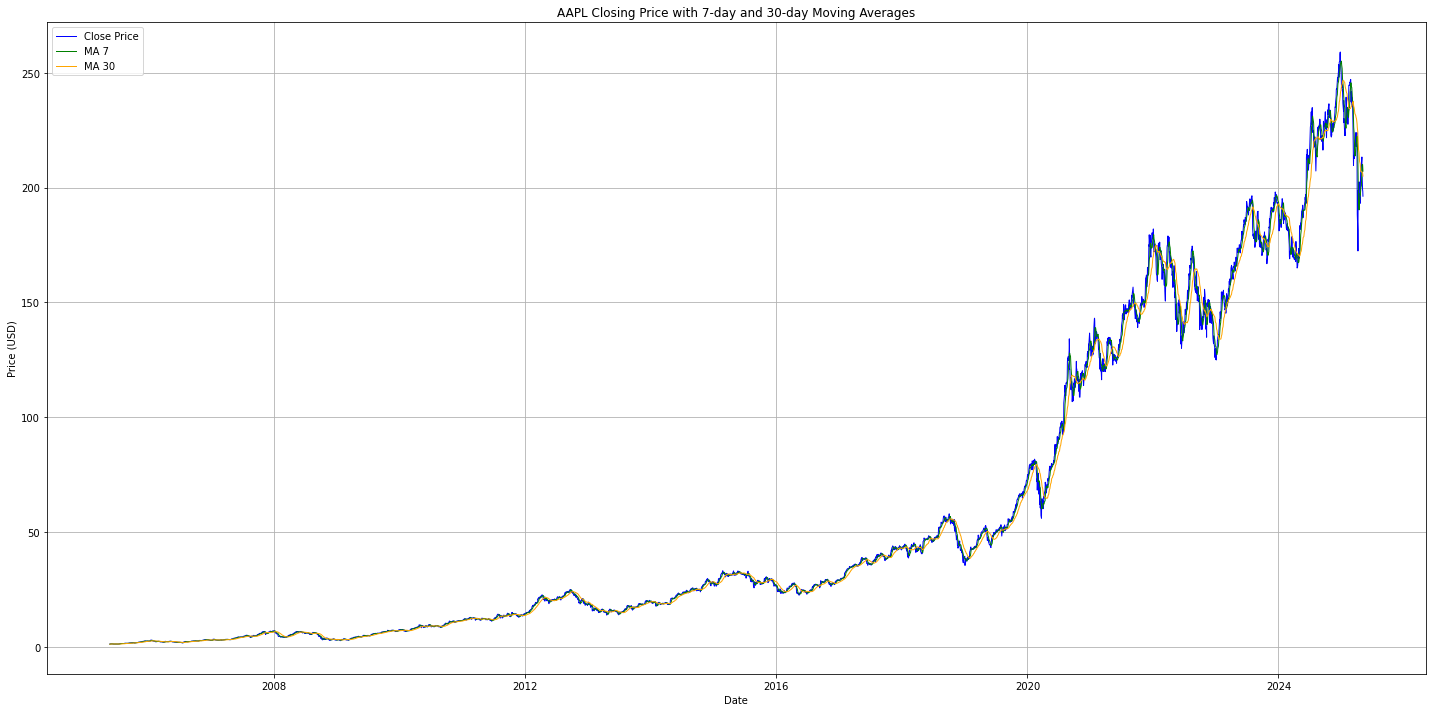

In [0]:
plt.figure(figsize=(20, 10))
plt.plot(pandas_df['Date'], pandas_df['close'], label='Close Price', color='blue', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['ma_7'], label='MA 7', color='green', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['ma_30'],label='MA 30', color='orange', linewidth=1)
plt.title('AAPL Closing Price with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

%md
* Apple’s closing price has increased dramatically
* When ma_7 crosses above ma_30, it's a bullish signal (uptrend forming). When it crosses below, it's bearish (downtrend forming)
* Sharp rises or drops in the price line suggest high volatility, especially visible before and after COVID in 2020 and in recent market corrections.

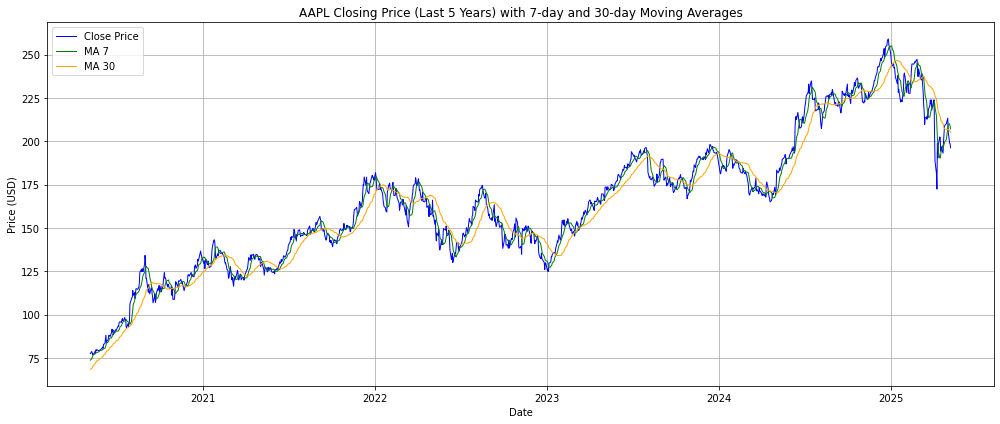

In [0]:
# Filter last 5 years only
cutoff_date = pandas_df['Date'].max() - pd.Timedelta(days=365*5)
plot_df = pandas_df[pandas_df['Date'] >= cutoff_date]

plt.figure(figsize=(14, 6))
plt.plot(plot_df['Date'], plot_df['close'], label='Close Price', color='blue', linewidth=1)
plt.plot(plot_df['Date'], plot_df['ma_7'], label='MA 7', color='green', linewidth=1)
plt.plot(plot_df['Date'], plot_df['ma_30'], label='MA 30', color='orange', linewidth=1)
plt.title('AAPL Closing Price (Last 5 Years) with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

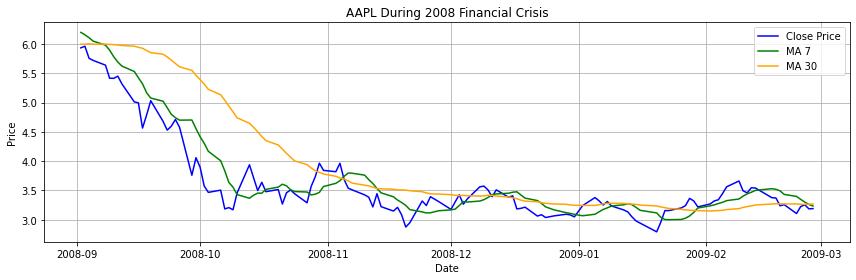

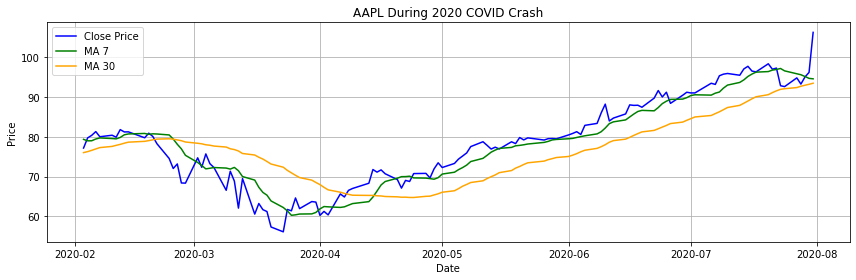

In [0]:
for label, start, end in [
    ("2008 Financial Crisis", "2008-09-01", "2009-03-01"),
    ("2020 COVID Crash", "2020-02-01", "2020-08-01")
]:
    zoom_df = pandas_df[(pandas_df['Date'] >= start) & (pandas_df['Date'] <= end)]
    plt.figure(figsize=(12, 4))
    plt.plot(zoom_df['Date'], zoom_df['close'], label='Close Price', color='blue')
    plt.plot(zoom_df['Date'], zoom_df['ma_7'], label='MA 7', color='green')
    plt.plot(zoom_df['Date'], zoom_df['ma_30'], label='MA 30', color='orange')
    plt.title(f'AAPL During {label}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 

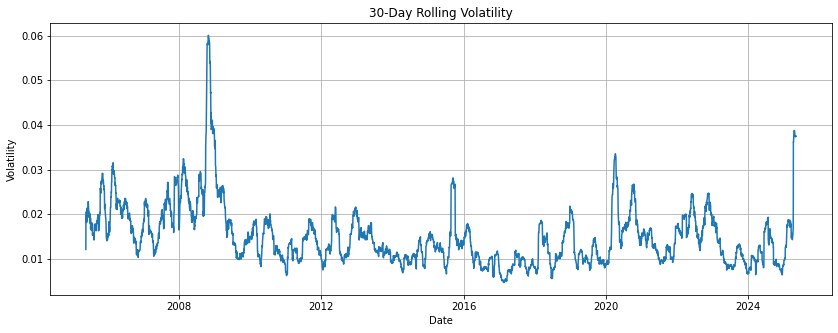

In [0]:
# --- Plot volatility with event annotations ---
plt.figure(figsize=(14, 5))
plt.plot(pandas_df['Date'], pandas_df['volatility_30'])
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

* Spikes in Volatility corresponds to market crises — 2008 financial crash, COVID crash. This is when market risk and investor uncertainty were extremely high
* Recurring smaller spikes - Could represent earnings reports, product launches, macroeconomic shocks, etc.